# <u>Boilerplate</u>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
import time

#  <u>Dataset description</u>

## Pre-processing the data

### VM table

In [3]:
vmtable = pd.read_csv('D:/FYP/AzureDatasetPacking2019/VM Table/vmtable.csv.gz', compression='gzip', 
                      names=['vm id', 'subscription id', 'deployment id', 'timestamp vm created', 'timestamp vm deleted', 
                             'max cpu', 'avg cpu', 'p95 max cpu', 'vm category', 'vm virtual core count', 
                             'vm memory (gb)'], sep=',', quotechar='"')
vmtable.shape

(2013767, 11)

#### <i>Calculate the lifetime of each VM (in minutes)</i>

In [4]:
vmtable['lifetime'] = (vmtable['timestamp vm deleted'] - vmtable['timestamp vm created'])/60

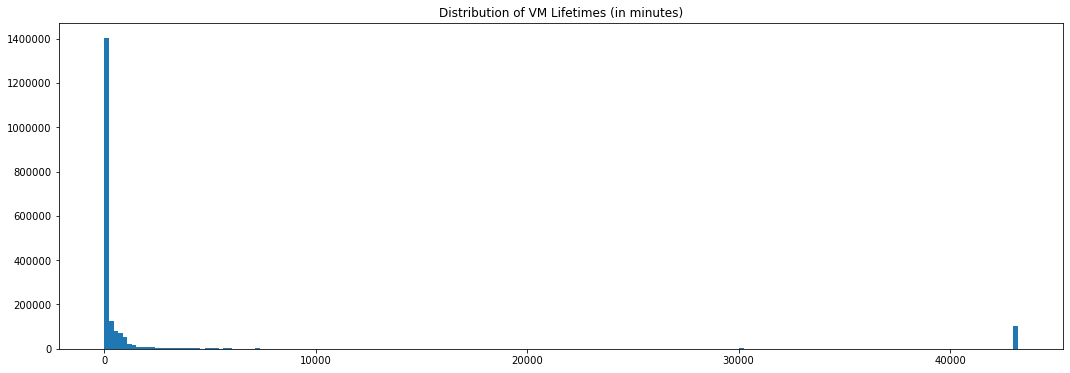

In [5]:
plt.figure(figsize=(18,6))
plt.hist(vmtable['lifetime'], bins=200)
plt.ticklabel_format(useOffset=False, style='plain')
plt.title('Distribution of VM Lifetimes (in minutes)')
plt.show()

#### <i>Convert the timestap to a datetime instance</i>

In [6]:
datetime_create = []
datetime_delete = []
# python assums timestamp 0 = 1970-01-01, for this data set 0 =July 15th 2019 and dataset ends July 28th 2019.
no_days_difference = datetime(2019, 7, 15, 0, 0) - datetime(1970, 1, 1, 0, 0) # = 18092
for ind, row in vmtable.iterrows():
    datetime_create.append(datetime.fromtimestamp(row['timestamp vm created']) + timedelta(days=18092))
    datetime_delete.append(datetime.fromtimestamp(row['timestamp vm deleted']) + timedelta(days=18092))
vmtable['datetime_creation'] = datetime_create
vmtable['datetime_deletion'] = datetime_delete

#### <i>Create a list of every five-minute interval</i>
Use each five-minute interval as a key in a dictionary (to be populated with the aggregated average, maximum, 95^th percentile maximum, core count and memory used within that time).

In [7]:
lifetime_range = pd.period_range(min(vmtable["datetime_creation"]), max(vmtable["datetime_deletion"]), freq="5min")
lifetime_range = list(lifetime_range.to_timestamp().to_pydatetime())

In [8]:
new_agg_vmtable = {}
for i in lifetime_range:
    # unique time interval = {avg cpu: 0, max cpu: 0, p95 max cpu: 0, core count: 0, memory: 0}
    new_agg_vmtable[i] = [0, 0, 0, 0, 0]

#### <i>Aggregate the data into five-minute intervals</i>
Due to the size of this table, this block takes several days to run.

The Process:

Get the creation and deletion datetime for each VM. If the datetime is not a multiple of five minutes, round it to the time interval that the VM is started within and apply a fractional weight which is equivalent to the percentage of the five minute interval that the VM is active for. For datetimes that are a multiple of five, a weight of one is applied.

For each five minute interval between the creation and deletion of each VM, the average, maximum, 95th percentile maximum, core count and memory usage are added to the dictionary new_agg_vmtable.

In [ ]:
start = time.time()
lt_rng = None
p = [1, 2, 4, 5, 12, 10, 15, 20, 25, 30, 45,50] # only needed to track progress
n = len(vmtable["datetime_creation"])
for i in range(n):
    # select the VM's start and endtime
    st = vmtable.iloc[i, :]["datetime_creation"]
    et = vmtable.iloc[i, :]["datetime_deletion"]
    # if start/end time not a multiple of 5 mins, set start/end time to previous five minute interval
    # calculate weight
    if st.minute % 5 != 0:
        start_time = st.floor("5min")
        start_weight = ((st.second - start_time.second) + (60 * (st.minute - start_time.minute))) / (60 * 5)
    # if start/end time is a five min interval, weight = 1
    else:
        start_time = st
        start_weight = 1 
    if et.minute % 5 != 0:
        end_time = et.floor("5min")
        end_weight = ((et.second - end_time.second) + (60 * (et.minute - end_time.minute))) / (60 * 5)
    else:
        end_time = et
        end_weight = 1
    # create list containing every 5 min period between start and end time of the VM
    lt_rnge = lifetime_range[lifetime_range.index(start_time):lifetime_range.index(end_time)] 
    # removing VM's that ran for more than 1000 five min periods to reduce computation time
    # from above histogram & Cortez et al. 2017, 90% of VM's run for less than 24 hours
    # the majority of the unused VM's run for the full month & are equivalent to adding a constant to the data
    if len(lt_rnge) < 1000: 
        for j in lt_rnge:
            # get current usage info for this period
            current_usage = new_agg_vmtable[j]
            # add current usage to usage for this VM & save
            # if start or end period, multiple VM usage by weight
            if lt_rnge.index(j) == 0:
                new_agg_vmtable[j] = [((vmtable.iloc[i, :]["avg cpu"] * start_weight) + current_usage[0]), 
                                  ((vmtable.iloc[i, :]["max cpu"]) + current_usage[1]),
                                  ((vmtable.iloc[i, :]["p95 max cpu"]) + current_usage[2]), 
                                  (vmtable.iloc[i, :]["vm virtual core count"] + current_usage[3]),
                                  (vmtable.iloc[i, :]["vm memory (gb)"] + current_usage[4])]
            elif lt_rnge.index(j) == n:
                new_agg_vmtable[j] = [((vmtable.iloc[i, :]["avg cpu"] * end_weight) + current_usage[0]), 
                                  ((vmtable.iloc[i, :]["max cpu"]) + current_usage[1]),
                                  ((vmtable.iloc[i, :]["p95 max cpu"]) + current_usage[2]), 
                                  (vmtable.iloc[i, :]["vm virtual core count"] + current_usage[3]),
                                  (vmtable.iloc[i, :]["vm memory (gb)"] + current_usage[4])]
            else:
                new_agg_vmtable[j] = [(vmtable.iloc[i, :]["avg cpu"] + current_usage[0]), 
                                  (vmtable.iloc[i, :]["max cpu"] + current_usage[1]),
                                  (vmtable.iloc[i, :]["p95 max cpu"] + current_usage[2]), 
                                  (vmtable.iloc[i, :]["vm virtual core count"] + current_usage[3]),
                                  (vmtable.iloc[i, :]["vm memory (gb)"] + current_usage[4])]
    # reset list containing every five min period
    lt_rng = []
    # ignore this! it just prints how long it takes to complete every 10% of the data
    if round((time.time() - start)/60) in p:
        print("%: ",(i/n) * 100,"\n time taken: ", (time.time() - start) / 60, "\n")
        p.remove(round((time.time() - start)/60))
end = time.time()
# prints total computation time
print((end-start)/60)

In [9]:
aggregation_vmtable = pd.read_csv("D:/FYP/AzureDatasetPacking2019/Aggregated Data/aggregated_vmtable.csv", header=0, 
                                  names= ["index", "avg_cpu", "max_cpu", "p95_max_cpu", "vm_virtual_core_count",
                                          "vm_memory_gb"])
aggregation_vmtable.head()

,index,avg_cpu,max_cpu,p95_max_cpu,vm_virtual_core_count,vm_memory_gb
0,2019-07-15 00:00:00,600026.793129,4.041458e+06,2.139499e+06,126757,335558.00
1,2019-07-15 00:05:00,600971.042478,4.044738e+06,2.141563e+06,126712,335395.25
2,2019-07-15 00:10:00,600301.813291,4.042657e+06,2.139025e+06,126516,334882.25
3,2019-07-15 00:15:00,599839.457380,4.042293e+06,2.138133e+06,126402,334636.75
4,2019-07-15 00:20:00,598782.239829,4.041869e+06,2.136908e+06,126265,334311.00


#### <i>Correct the datetime instances</i>

In [10]:
days_difference = datetime(2019, 7, 15, 0, 0) - datetime(2016, 11, 16, 0, 0) # 971 days
aggregation_vmtable = aggregation_vmtable.reset_index()
aggregation_vmtable["index"] = pd.to_datetime(aggregation_vmtable["index"]) - timedelta(days=971)
aggregation_vmtable = aggregation_vmtable.set_index("index")
aggregation_vmtable = aggregation_vmtable[["avg_cpu", "max_cpu", "p95_max_cpu", "vm_virtual_core_count", "vm_memory_gb"]]

In [ ]:
aggregation_vmtable.to_csv("D:/FYP/AzureDatasetPacking2019/Aggregated Data/aggregated_vmtable_correct_dates.csv")

In [11]:
aggregation_vmtable.tail()

,avg_cpu,max_cpu,p95_max_cpu,vm_virtual_core_count,vm_memory_gb
index,,,,,
2016-12-15 23:35:00,625220.260839,4.478651e+06,2.229860e+06,129979,337958.75
2016-12-15 23:40:00,622813.265551,4.468815e+06,2.223262e+06,129731,337061.75
2016-12-15 23:45:00,619207.294106,4.450889e+06,2.209649e+06,129230,336097.00
2016-12-15 23:50:00,615505.559907,4.433751e+06,2.196580e+06,128805,334848.25
2016-12-15 23:55:00,0.000000,0.000000e+00,0.000000e+00,0,0.00


***

### CPU readings
#### <i>Aggregate the individual files</i>
Sum the maximum and average CPU readings for each timestamp.

In [ ]:
# for each CPU Reading file
for file in os.listdir("F:/FYP/AzureDatasetPacking2019/VM CPU Readings"):
    cpu_memory_reading = pd.read_csv("F:/FYP/AzureDatasetPacking2019/VM CPU Readings/" + file, compression='gzip', 
                                 names=['timestamp', 'vm id', 'min cpu', 'max cpu', 'avg cpu'], sep=',', quotechar='"')
    # aggregate avg. & max. cpu usage by timestamp
    cpu_memory_reading = cpu_memory_reading.groupby('timestamp').agg({"avg cpu":'sum','max cpu':'sum'})
    # save aggregated file
    cpu_memory_reading.to_csv("C:/Users/ehlocal/OneDrive - University College Cork/UCC/Year 4/FYP/CPU Memory Aggregation 2/" + str(file[0:-7]) + ".csv")

#### <i>Combine the files</i>

In [12]:
aggregated_cpu_readings = pd.DataFrame()
for file in os.listdir("D:/FYP/AzureDatasetPacking2019/Aggregated Data/CPU Readings Aggregation"):
    individ_file = pd.read_csv("D:/FYP/AzureDatasetPacking2019/Aggregated Data/CPU Readings Aggregation/" + file)
    # append aggregated CPU Reading files into one file
    aggregated_cpu_readings = aggregated_cpu_readings.append(individ_file)

In [13]:
aggregated_cpu_readings.head()

,timestamp,avg cpu,max cpu
0,0,1.229569e+06,2.223302e+06
1,300,1.211322e+06,2.212393e+06
2,600,1.206635e+06,2.213057e+06
3,900,1.190369e+06,2.187572e+06
4,1200,1.180992e+06,2.183684e+06


#### <i>Remove duplicate datetimes by re-aggregating the combined file</i>
Duplicate timestamps appears because the individual files were ordered by time. Therefore, the final datetime in one file was the same as the initial datetime in the succeeding file.

In [14]:
aggregated_cpu_readings.shape

(11641, 3)

In [15]:
len(np.unique(aggregated_cpu_readings["timestamp"])) # no. of unique timestamps

11517

In [16]:
aggregated_cpu_readings[aggregated_cpu_readings["timestamp"].duplicated(keep=False)] # 248 rows of duplicated timestamps

,timestamp,avg cpu,max cpu
70,21000,7.566361e+05,1.451319e+06
0,188400,5.870905e+05,1.115624e+06
71,209700,3.570706e+05,6.690535e+05
0,2061600,1.077751e+06,1.940617e+06
138,2082300,7.953052e+05,1.454434e+06
...,...,...,...
142,2020200,2.723892e+05,4.982031e+05
0,2020200,8.747763e+05,1.601421e+06
140,2041200,2.942990e+05,5.201345e+05
0,2041200,1.030168e+06,1.825420e+06


In [17]:
11641 - 11517 # number of duplicates 

124

In [18]:
aggregated_cpu_readings = aggregated_cpu_readings.groupby('timestamp').agg({"avg cpu":'sum','max cpu':'sum'})

In [34]:
aggregated_cpu_readings.to_csv("D:/FYP/AzureDatasetPacking2019/Aggregated Data/aggregated_cpu_readings_TSerror.csv")

In [19]:
aggregated_cpu_readings = pd.read_csv("D:/FYP/AzureDatasetPacking2019/Aggregated Data/aggregated_cpu_readings_TSerror.csv")
aggregated_cpu_readings.head()

,Unnamed: 0,timestamp,avg cpu,max cpu
0,0,0,1.229569e+06,2.223302e+06
1,1,300,1.211322e+06,2.212393e+06
2,2,600,1.206635e+06,2.213057e+06
3,3,900,1.190369e+06,2.187572e+06
4,4,1200,1.180992e+06,2.183684e+06


In [20]:
aggregated_cpu_readings = aggregated_cpu_readings.drop(columns=["Unnamed: 0"])
aggregated_cpu_readings = aggregated_cpu_readings.set_index("timestamp")
aggregated_cpu_readings.head()

,avg cpu,max cpu
timestamp,,
0,1.229569e+06,2.223302e+06
300,1.211322e+06,2.212393e+06
600,1.206635e+06,2.213057e+06
900,1.190369e+06,2.187572e+06
1200,1.180992e+06,2.183684e+06


#### <i>Visualise the aggregated data</i>

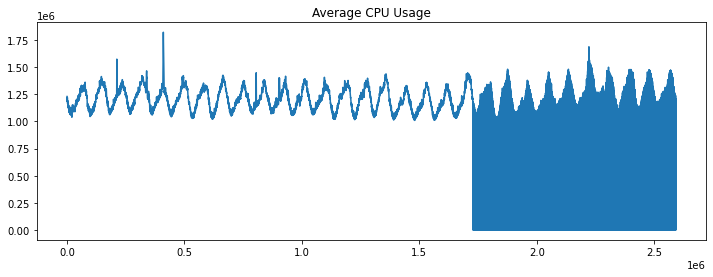

In [21]:
# load in the pre-processed data with TimeStamp error
plt.figure(figsize=(12,4))
plt.plot(aggregated_cpu_readings["avg cpu"])
plt.title("Average CPU Usage")
plt.show()

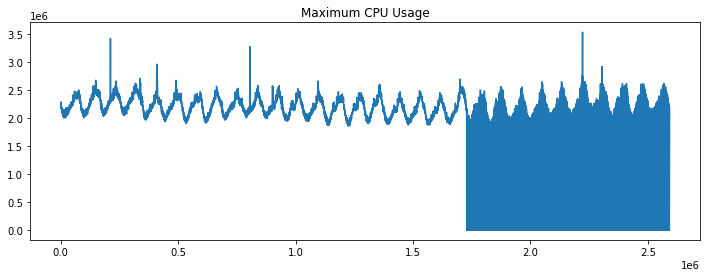

In [22]:
plt.figure(figsize=(12,4))
plt.plot(aggregated_cpu_readings["max cpu"])
plt.title("Maximum CPU Usage")
plt.show()

In [23]:
print("No. of Rows with Timestamp not a multiple of 5 minutes: ", ((aggregated_cpu_readings.index % 300 != 0)).sum())
print("Total No. of Rows: ", len(aggregated_cpu_readings.index))

No. of Rows with Timestamp not a multiple of 5 minutes:  2877
Total No. of Rows:  11517


#### <i>Fix the aggregated data</i>
The large fluctuation seen in the above plots was caused by the timestamp on several of the CPU Reading files being out of sync and recording data for different 5 minute windows compared to the rest of the readings. 

To resolve this, for each out of synce timestamp recorded, the correct timestamp that occured before and after the out of sync time stamp was obtained. A weight, which was calculated to be the fraction for which the aggregated average and maximum cpu ran for in the correct preceding and succeeding timestamps, was applied to the recorded usage and a new row for both the preceding and succeeding timestamps was added to a temporary dataframe (along with their corresponding usage recordings).  

The rows with out of sync time stamps were deleted from aggregated_cpu. The temporary dataframe was concatonated onto aggregated_cpu and the resulting data frame was grouped by timestamp to sum the recorded average and max usage.

In [24]:
sub_df = pd.DataFrame()
for time in aggregated_cpu_readings.index:
    if time % 300 != 0:
        # create timestamp for 5 minute period before and after
        new_time1 = np.floor((time/(300)))*300
        new_time2 = np.ceil((time/(300)))*300
        # create weight for the timestamp before and after the out of sync timestamp
        weight = ((time % 300) / 300)
        weight1 = 1 - weight
        weight2 = weight
        # calculcate the weighted avg and max cpu for each timestamp
        avg_c = aggregated_cpu_readings.loc[time, "avg cpu"]
        max_c = aggregated_cpu_readings.loc[time, "max cpu"]
        min_entry = pd.DataFrame({"timestamp":new_time1, "avg cpu": weight1*avg_c, "max cpu":weight1*max_c }, index=[0])
        max_entry = pd.DataFrame({"timestamp":new_time2, "avg cpu": weight2*avg_c, "max cpu":weight2*max_c }, index=[0])
        # add weighted usage into new row in a temporary dataframe
        sub_df = pd.concat([sub_df, min_entry])
        sub_df = pd.concat([sub_df, max_entry])

# drop rows with out of sync entries
aggregated_cpu_readings = aggregated_cpu_readings.drop(aggregated_cpu_readings[aggregated_cpu_readings.index % 300 != 0].index)
# add in new entries with weight corrected values to replace the deleted entries
aggregated_cpu_readings = pd.concat([aggregated_cpu_readings.reset_index(), sub_df])
# aggregate
aggregated_cpu_readings = aggregated_cpu_readings.groupby('timestamp').agg({"avg cpu":'sum','max cpu':'sum'})

In [25]:
aggregated_cpu_readings.to_csv("D:/FYP/AzureDatasetPacking2019/Aggregated Data/aggregated_cpu_readings_TSfixed.csv")

In [27]:
aggregated_cpu_readings = pd.read_csv("D:/FYP/AzureDatasetPacking2019/Aggregated Data/aggregated_cpu_readings_TSfixed.csv")
# aggregated_cpu_readings = aggregated_cpu_readings.drop(columns=["Unnamed: 0"])
aggregated_cpu_readings = aggregated_cpu_readings.set_index("timestamp")
aggregated_cpu_readings.head()

,avg cpu,max cpu
timestamp,,
0.0,1.229569e+06,2.223302e+06
300.0,1.211322e+06,2.212393e+06
600.0,1.206635e+06,2.213057e+06
900.0,1.190369e+06,2.187572e+06
1200.0,1.180992e+06,2.183684e+06


#### <i>Visualise the fixed data</i>

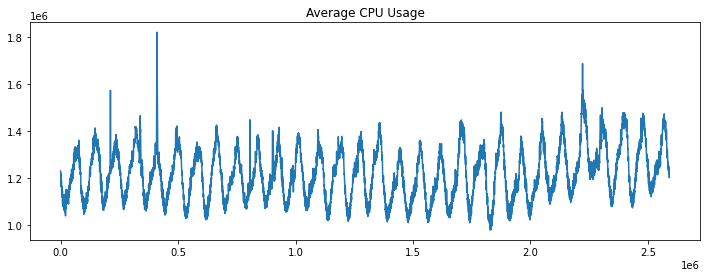

In [28]:
plt.figure(figsize=(12,4))
plt.plot(aggregated_cpu_readings["avg cpu"])
plt.title('Average CPU Usage')
plt.show()

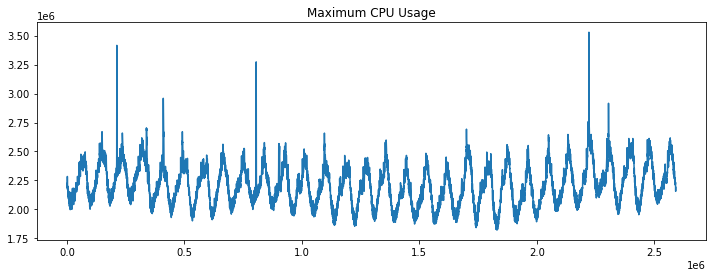

In [29]:
plt.figure(figsize=(12,4))
plt.plot(aggregated_cpu_readings["max cpu"])
plt.title('Maximum CPU Usage')
plt.show()

#### <i>Convert the timestap to a datetime instance</i>

In [30]:
no_days_difference =  datetime(2016, 11, 16, 0, 0)  - datetime(1970, 1, 1, 0, 0) # = 17121
date_time = []
for time in aggregated_cpu_readings.index:
    date_t = datetime.fromtimestamp(time) + timedelta(days=no_days_difference.days)
    date_time.append(date_t)
aggregated_cpu_readings["datetime"] = date_time

aggregated_cpu_readings = aggregated_cpu_readings.set_index("datetime")

In [31]:
aggregated_cpu_readings.head()

,avg cpu,max cpu
datetime,,
2016-11-16 00:00:00,1.229569e+06,2.223302e+06
2016-11-16 00:05:00,1.211322e+06,2.212393e+06
2016-11-16 00:10:00,1.206635e+06,2.213057e+06
2016-11-16 00:15:00,1.190369e+06,2.187572e+06
2016-11-16 00:20:00,1.180992e+06,2.183684e+06


In [78]:
aggregated_cpu_readings.to_csv("D:/FYP/AzureDatasetPacking2019/Aggregated Data/aggregated_cpu_readings_correctdates.csv")

### Combine the CPU readings and VM table

In [32]:
aggregation_vmtable = aggregation_vmtable.reset_index()
aggregation_vmtable = aggregation_vmtable.rename({'index': 'datetime'}, axis=1)
aggregation_vmtable = aggregation_vmtable.set_index("datetime")

In [33]:
aggregation_vmtable = aggregation_vmtable.rename(columns={'index': 'datetime'})
all_data = pd.merge(aggregated_cpu_readings, aggregation_vmtable, left_index=True, right_index=True)
all_data = all_data.rename(columns={'avg cpu': 'avg cpu reading', 'avg_cpu': 'avg cpu VMTable',
                                    'max cpu': 'max cpu reading', 'max_cpu': 'max cpu VMTable',
                                    'vm_virtual_core_count': 'core count', 'vm_memory_gb': 'memory (gb)'})
all_data.head()

,avg cpu reading,max cpu reading,avg cpu VMTable,max cpu VMTable,p95_max_cpu,core count,memory (gb)
datetime,,,,,,,
2016-11-16 00:00:00,1.229569e+06,2.223302e+06,600026.793129,4.041458e+06,2.139499e+06,126757,335558.00
2016-11-16 00:05:00,1.211322e+06,2.212393e+06,600971.042478,4.044738e+06,2.141563e+06,126712,335395.25
2016-11-16 00:10:00,1.206635e+06,2.213057e+06,600301.813291,4.042657e+06,2.139025e+06,126516,334882.25
2016-11-16 00:15:00,1.190369e+06,2.187572e+06,599839.457380,4.042293e+06,2.138133e+06,126402,334636.75
2016-11-16 00:20:00,1.180992e+06,2.183684e+06,598782.239829,4.041869e+06,2.136908e+06,126265,334311.00


In [81]:
all_data.to_csv("D:/FYP/AzureDatasetPacking2019/Aggregated Data/all_data.csv")

### Formatting the data for forecasting
#### <i>Remove trend from the time series</i>
(detrend,normalisation, rolling window, two & three step ahead)

In [34]:
all_data = all_data.diff()
all_data = all_data.drop(all_data.head(1).index) # first row is Null
all_data.head()

,avg cpu reading,max cpu reading,avg cpu VMTable,max cpu VMTable,p95_max_cpu,core count,memory (gb)
datetime,,,,,,,
2016-11-16 00:05:00,-18247.662562,-10909.187252,944.249350,3279.578777,2063.958099,-45.0,-162.75
2016-11-16 00:10:00,-4686.794736,663.499454,-669.229187,-2080.483273,-2537.347221,-196.0,-513.00
2016-11-16 00:15:00,-16266.407090,-25484.505811,-462.355911,-364.112724,-892.153017,-114.0,-245.50
2016-11-16 00:20:00,-9376.819149,-3887.753457,-1057.217552,-423.895115,-1225.400686,-137.0,-325.75
2016-11-16 00:25:00,39297.268601,100597.082507,-4534.552752,-12107.873949,-11858.432480,-772.0,-1831.00


In [83]:
all_data.to_csv("D:/FYP/AzureDatasetPacking2019/Aggregated Data/all_data_differneciated.csv")

#### <i>Divide into train and test sets</i>

In [35]:
train, test = train_test_split(all_data, test_size = 0.2, random_state= 1, shuffle=False)
train.shape, test.shape

((6911, 7), (1728, 7))

#### <i>Normalise the data</i>

In [36]:
scaler = MinMaxScaler()
col_names = ['avg cpu reading', 'max cpu reading', 'avg cpu VMTable', 'max cpu VMTable', 'p95_max_cpu', 'core count', 'memory (gb)']
# scale the training set
train[col_names] = scaler.fit_transform(train[col_names])
# apply the scale to the test set
test[col_names] = scaler.transform(test[col_names])

In [37]:
norm_data = pd.concat([train, test])

In [38]:
norm_data.head()

,avg cpu reading,max cpu reading,avg cpu VMTable,max cpu VMTable,p95_max_cpu,core count,memory (gb)
datetime,,,,,,,
2016-11-16 00:05:00,0.473108,0.507159,0.642697,0.389070,0.457200,0.542533,0.556540
2016-11-16 00:10:00,0.497531,0.513979,0.621276,0.368893,0.436491,0.526355,0.537675
2016-11-16 00:15:00,0.476676,0.498570,0.624023,0.375354,0.443895,0.535140,0.552083
2016-11-16 00:20:00,0.489084,0.511297,0.616125,0.375129,0.442395,0.532676,0.547761
2016-11-16 00:25:00,0.576745,0.572872,0.569960,0.331148,0.394540,0.464645,0.466687


In [87]:
norm_data.to_csv("C:/Users/user/OneDrive - University College Cork/UCC/Year 4/FYP/Normalised Data/all_data_norm.csv")